# Outlier Detection Dataset - Statistical Analysis

 A statistical analysis of the outlier detection dataset including:
- Video length distribution (Short/Medium/Long)
- Outlier frame positions and patterns
- Normal vs Outlier frame ratios
- Cross-action outlier sources
- Temporal distribution of outliers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
csv_dir = Path('./outlier_artifacts/outlier_CSVs')
csv_files = sorted(list(csv_dir.glob('*.csv')))

print(f"Found {len(csv_files)} action categories")
print(f"\nFirst 10 actions: {[f.stem for f in csv_files[:10]]}")

all_data = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    df['action'] = csv_file.stem
    all_data.append(df)

df_all = pd.concat(all_data, ignore_index=True)

print(f"\nLoaded {len(df_all):,} frames from {df_all['video_id'].nunique()} videos")
print(f"  Actions: {df_all['action'].nunique()}")
print(f"  Total outlier frames: {df_all['is_outlier'].sum():,}")
print(f"  Total normal frames: {(df_all['is_outlier'] == 0).sum():,}")

Found 40 action categories

First 10 actions: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress']

Loaded 235,049 frames from 1000 videos
  Actions: 40
  Total outlier frames: 39,275
  Total normal frames: 195,774



Loaded 235,049 frames from 1000 videos
  Actions: 40
  Total outlier frames: 39,275
  Total normal frames: 195,774


## 1. Video Length Distribution (Short/Medium/Long)

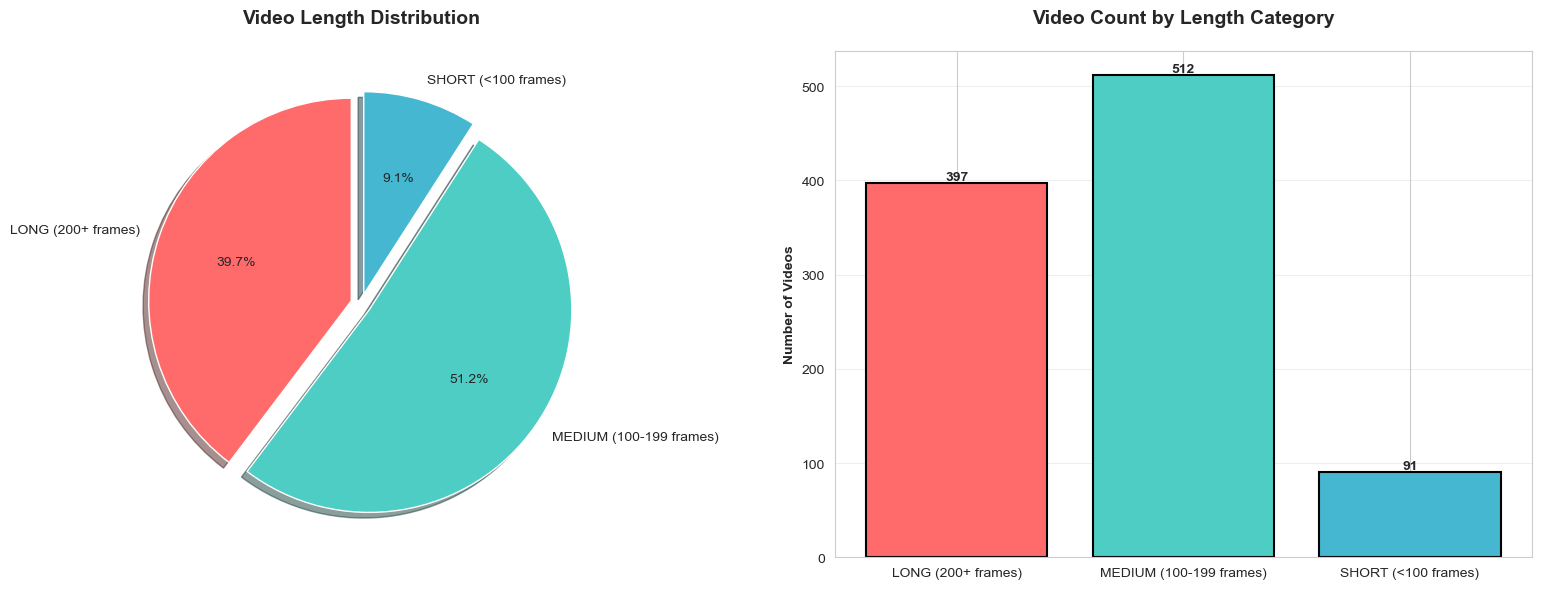

In [3]:
video_stats = df_all.groupby('video_id').agg({
    'frame_id': 'count',
    'is_outlier': 'sum',
    'action': 'first'
}).rename(columns={'frame_id': 'total_frames', 'is_outlier': 'outlier_count'})

video_stats['normal_frames'] = video_stats['total_frames'] - video_stats['outlier_count']

# Categorize videos by length
def categorize_length(num_frames):
    if num_frames < 100:
        return 'SHORT (<100 frames)'
    elif num_frames < 200:
        return 'MEDIUM (100-199 frames)'
    else:
        return 'LONG (200+ frames)'

video_stats['length_category'] = video_stats['normal_frames'].apply(categorize_length)

# Count videos by category
length_distribution = video_stats['length_category'].value_counts().sort_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
explode = (0.05, 0.05, 0.05)
ax1.pie(length_distribution.values, labels=length_distribution.index, autopct='%1.1f%%',
        colors=colors, explode=explode, shadow=True, startangle=90)
ax1.set_title('Video Length Distribution', fontsize=14, fontweight='bold', pad=20)

bars = ax2.bar(range(len(length_distribution)), length_distribution.values, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_xticks(range(len(length_distribution)))
ax2.set_xticklabels(length_distribution.index, rotation=0)
ax2.set_ylabel('Number of Videos', fontweight='bold')
ax2.set_title('Video Count by Length Category', fontsize=14, fontweight='bold', pad=20)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('./outlier_artifacts/statistics/analysis_video_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Outlier Count Distribution by Video Length

Outlier Statistics by Video Length:
                          mean   std  min  max  median
length_category                                       
LONG (200+ frames)       62.46  7.51   42   80    62.0
MEDIUM (100-199 frames)  26.50  2.81   19   33    26.0
SHORT (<100 frames)      10.00  0.00   10   10    10.0


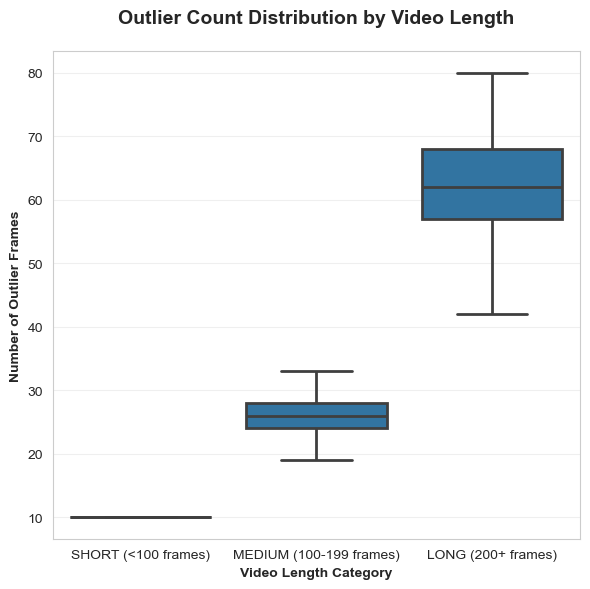

In [4]:
# Analyze outlier counts by video length category
order = ['SHORT (<100 frames)', 'MEDIUM (100-199 frames)', 'LONG (200+ frames)']

outlier_by_length = video_stats.groupby('length_category')['outlier_count'].agg(['mean', 'std', 'min', 'max', 'median'])

print("Outlier Statistics by Video Length:")
print("=" * 80)
print(outlier_by_length.round(2))

fig, ax = plt.subplots(figsize=(6, 6))

# Box plot
sns.boxplot(data=video_stats, x='length_category', y='outlier_count', 
            order=order, ax=ax, linewidth=2)
ax.set_xlabel('Video Length Category', fontweight='bold')
ax.set_ylabel('Number of Outlier Frames', fontweight='bold')
ax.set_title('Outlier Count Distribution by Video Length', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./outlier_artifacts/statistics/analysis_outlier_count_by_length.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Normal Frames vs Outlier Frames Ratio

Overall Frame Distribution:
Total Frames:    235,049
Normal Frames:   195,774 (83.29%)
Outlier Frames:  39,275 (16.71%)
Ratio (N:O):     4.98:1


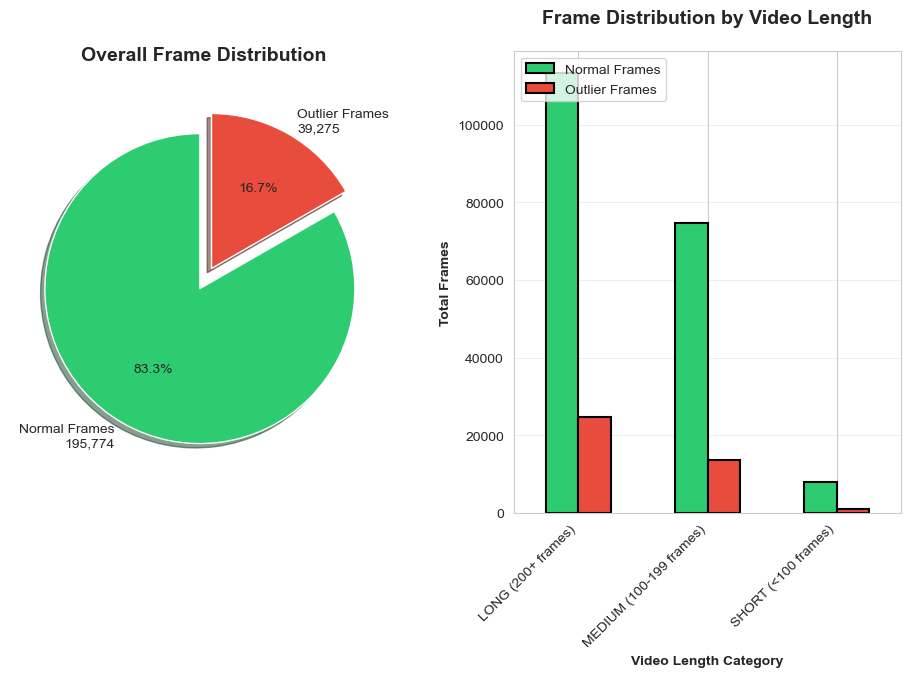

In [5]:
# Overall ratio
total_normal = (df_all['is_outlier'] == 0).sum()
total_outliers = df_all['is_outlier'].sum()
total_frames = len(df_all)

print("Overall Frame Distribution:")
print("=" * 50)
print(f"Total Frames:    {total_frames:,}")
print(f"Normal Frames:   {total_normal:,} ({total_normal/total_frames*100:.2f}%)")
print(f"Outlier Frames:  {total_outliers:,} ({total_outliers/total_frames*100:.2f}%)")
print(f"Ratio (N:O):     {total_normal/total_outliers:.2f}:1")

fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 3, wspace=0.3)

# 1. Overall pie chart
ax1 = fig.add_subplot(gs[0, 0])
sizes = [total_normal, total_outliers]
labels = [f'Normal Frames\n{total_normal:,}', f'Outlier Frames\n{total_outliers:,}']
colors_ratio = ['#2ECC71', '#E74C3C']
explode = (0.05, 0.1)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors_ratio, 
        explode=explode, shadow=True, startangle=90)
ax1.set_title('Overall Frame Distribution', fontsize=14, fontweight='bold', pad=20)

# 2. Ratio by video length
ax2 = fig.add_subplot(gs[0, 1])
ratio_by_length = video_stats.groupby('length_category')[['normal_frames', 'outlier_count']].sum()
ratio_by_length.plot(kind='bar', stacked=False, ax=ax2, color=['#2ECC71', '#E74C3C'], 
                      edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Video Length Category', fontweight='bold')
ax2.set_ylabel('Total Frames', fontweight='bold')
ax2.set_title('Frame Distribution by Video Length', fontsize=14, fontweight='bold', pad=20)
ax2.legend(['Normal Frames', 'Outlier Frames'], loc='upper left')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

plt.savefig('./outlier_artifacts/statistics/analysis_normal_vs_outlier_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Outlier Position Analysis (First Frame / Middle Frames / Last Frame)

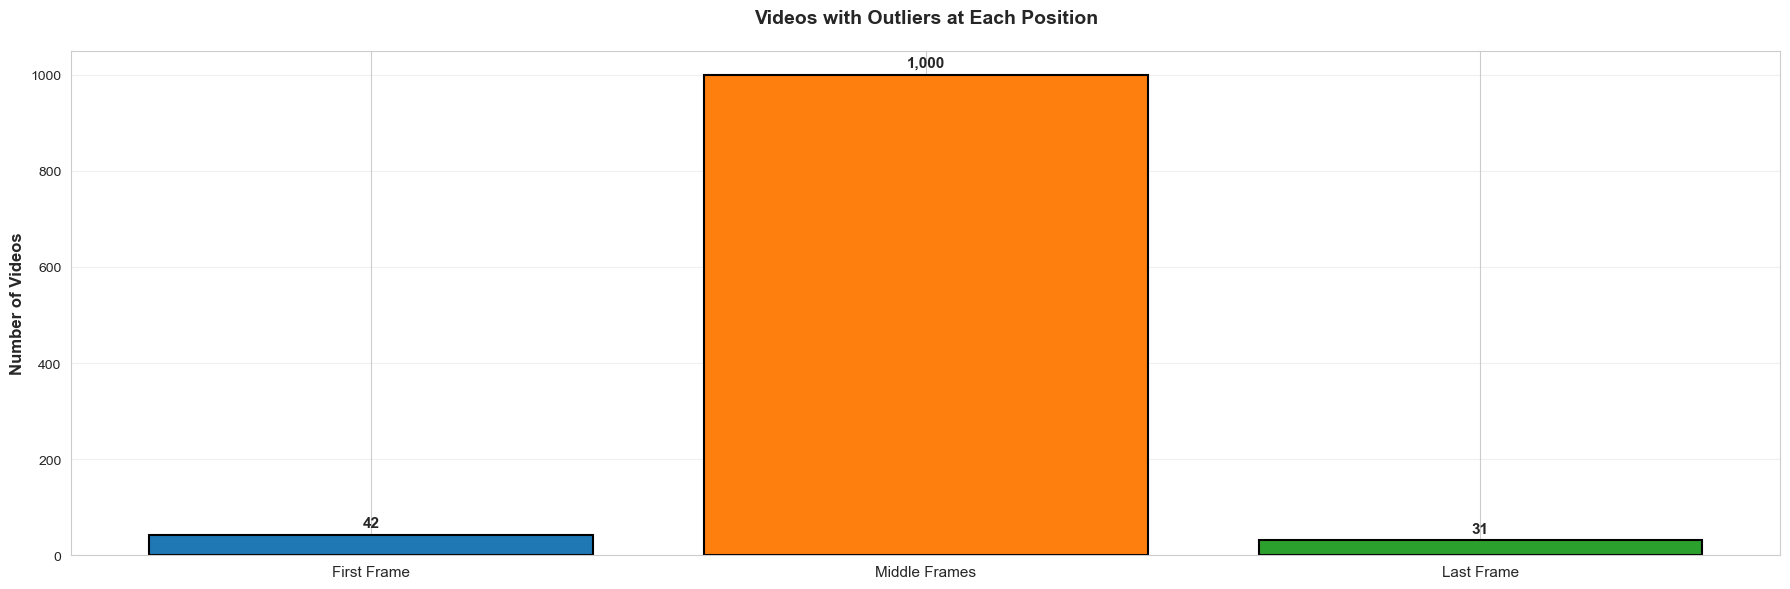

In [6]:
# Analyze outlier positions: First frame, Middle frames, Last frame
def get_position_category(row, video_max_frames):
    """Categorize frame position as First, Middle, or Last frame."""
    video_id = row['video_id']
    frame_id = row['frame_id']
    max_frame = video_max_frames[video_id]
    
    if frame_id == 0:
        return 'First Frame'
    elif frame_id == max_frame:
        return 'Last Frame'
    else:
        return 'Middle Frames'

video_max_frames = df_all.groupby('video_id')['frame_id'].max().to_dict()

outliers_df = df_all[df_all['is_outlier'] == 1].copy()
outliers_df['position'] = outliers_df.apply(lambda row: get_position_category(row, video_max_frames), axis=1)

# Count outliers by position
position_distribution = outliers_df['position'].value_counts()
position_order = ['First Frame', 'Middle Frames', 'Last Frame']
position_distribution = position_distribution.reindex(position_order, fill_value=0)

position_stats_per_video = {}
for video_id in df_all['video_id'].unique():
    video_outliers = outliers_df[outliers_df['video_id'] == video_id]
    positions = video_outliers['position'].value_counts()
    
    for pos in position_order:
        if pos not in position_stats_per_video:
            position_stats_per_video[pos] = {'videos_with_outliers': 0, 'total_outliers': 0}
        
        if pos in positions.index and positions[pos] > 0:
            position_stats_per_video[pos]['videos_with_outliers'] += 1
            position_stats_per_video[pos]['total_outliers'] += positions[pos]


# Visualization
fig, ax = plt.subplots(figsize=(18, 6))

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    percentage = (position_distribution.values[i] / len(outliers_df)) * 100 if len(outliers_df) > 0 else 0
    ax1.text(width + 200, bar.get_y() + bar.get_height()/2.,
             f'{int(width):,} ({percentage:.1f}%)',
             ha='left', va='center', fontweight='bold', fontsize=11)

# 2. Bar chart - Number of videos with outliers at each position
video_counts = [position_stats_per_video[pos]['videos_with_outliers'] for pos in position_order]
colors_pos = ['tab:blue', 'tab:orange', 'tab:green']  
bars2 = ax.bar(range(len(position_order)), video_counts, color=colors_pos, 
                edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(position_order)))
ax.set_xticklabels(position_order, fontsize=11)
ax.set_ylabel('Number of Videos', fontweight='bold', fontsize=12)
ax.set_title('Videos with Outliers at Each Position', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{int(height):,}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('./outlier_artifacts/statistics/analysis_outlier_position.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Cross-Action Outlier Source Analysis

Top 15 Most Used Outlier Source Actions:
 1. HammerThrow              : 1,202 times ( 3.06%)
 2. BabyCrawling             : 1,163 times ( 2.96%)
 3. Archery                  : 1,131 times ( 2.88%)
 4. CuttingInKitchen         : 1,104 times ( 2.81%)
 5. HeadMassage              : 1,079 times ( 2.75%)
 6. FrontCrawl               : 1,076 times ( 2.74%)
 7. BasketballDunk           : 1,069 times ( 2.72%)
 8. BandMarching             : 1,052 times ( 2.68%)
 9. HighJump                 : 1,049 times ( 2.67%)
10. HandstandWalking         : 1,040 times ( 2.65%)
11. BoxingPunchingBag        : 1,038 times ( 2.64%)
12. FieldHockeyPenalty       : 1,032 times ( 2.63%)
13. GolfSwing                : 1,025 times ( 2.61%)
14. Fencing                  : 1,024 times ( 2.61%)
15. BalanceBeam              : 1,024 times ( 2.61%)


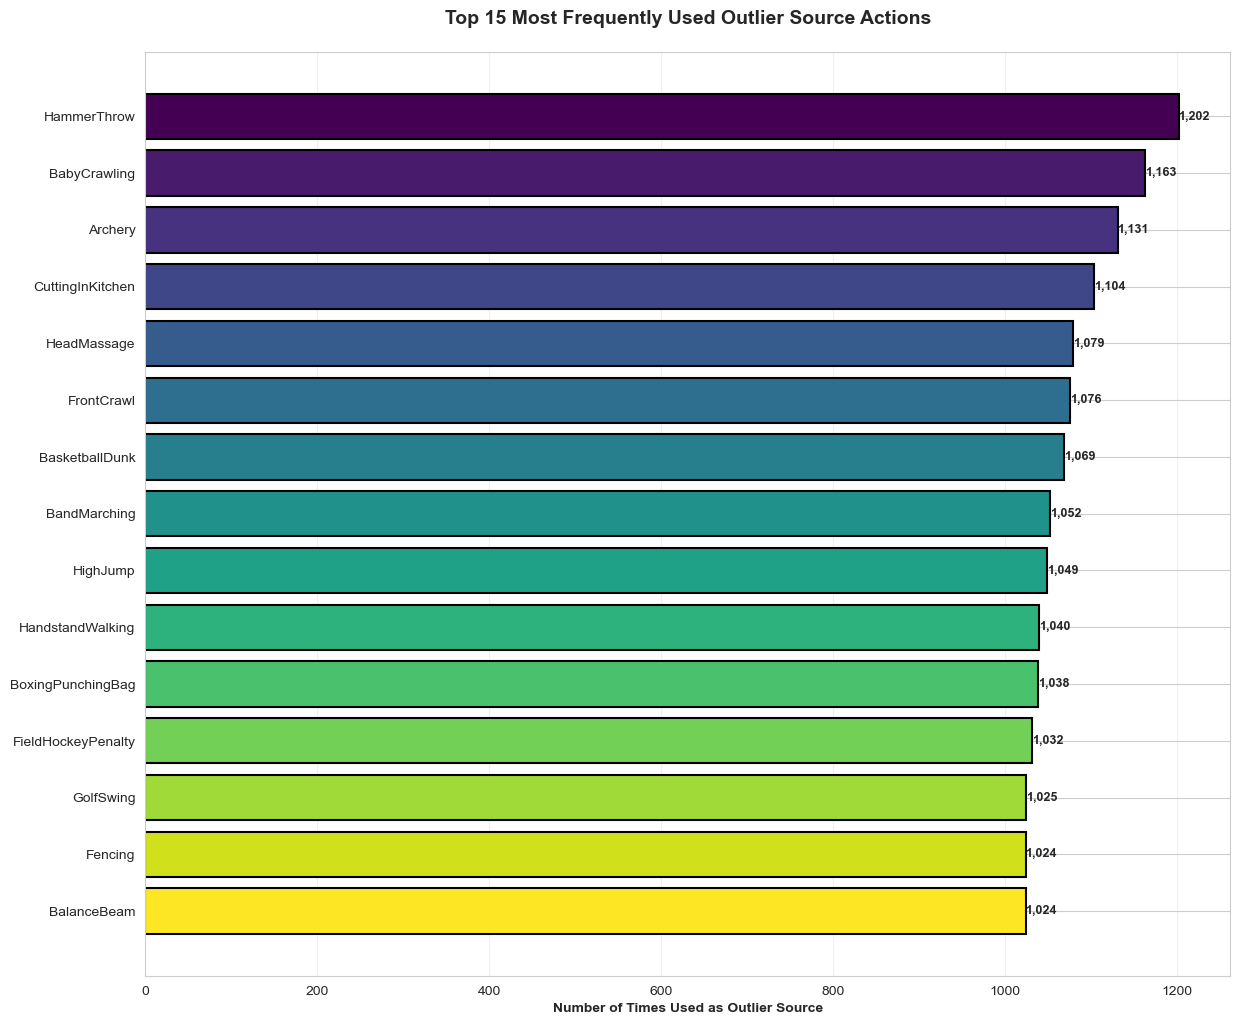

In [7]:
# Analyze which actions are used as outlier sources
outlier_sources = outliers_df['outlier_source'].dropna()

# Extract action name from source video filename
def extract_action_from_video(video_name):
    if pd.isna(video_name):
        return None
    # Format: v_ActionName_g##_c##.avi
    parts = video_name.split('_')
    if len(parts) >= 2:
        return parts[1]
    return None

outliers_df['source_action'] = outliers_df['outlier_source'].apply(extract_action_from_video)

# Top 15 most used source actions
top_sources = outliers_df['source_action'].value_counts().head(15)

print("Top 15 Most Used Outlier Source Actions:")
print("=" * 60)
for i, (action, count) in enumerate(top_sources.items(), 1):
    percentage = (count / len(outliers_df)) * 100
    print(f"{i:2d}. {action:25s}: {count:5,} times ({percentage:5.2f}%)")

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# Top sources bar chart
colors_gradient = plt.cm.viridis(np.linspace(0, 1, len(top_sources)))
bars = ax.barh(range(len(top_sources)), top_sources.values, color=colors_gradient,
                edgecolor='black', linewidth=1.5)
ax.set_yticks(range(len(top_sources)))
ax.set_yticklabels(top_sources.index)
ax.set_xlabel('Number of Times Used as Outlier Source', fontweight='bold')
ax.set_title('Top 15 Most Frequently Used Outlier Source Actions', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
             f'{int(width):,}',
             ha='left', va='center', fontweight='bold', fontsize=9)

plt.savefig('./outlier_artifacts/statistics/analysis_outlier_sources.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Outlier Segment Analysis (Consecutive vs Isolated)

Outlier Segment Analysis:
Total segments: 7570

Segment Types:
  Isolated (1 frame):           3,462 ( 45.7%)
  Short consecutive (2-5):      1,359 ( 18.0%)
  Medium consecutive (6-10):    1,967 ( 26.0%)
  Long consecutive (11+):         782 ( 10.3%)

Average segment length: 5.19 frames
Median segment length:  3 frames
Max segment length:     33 frames


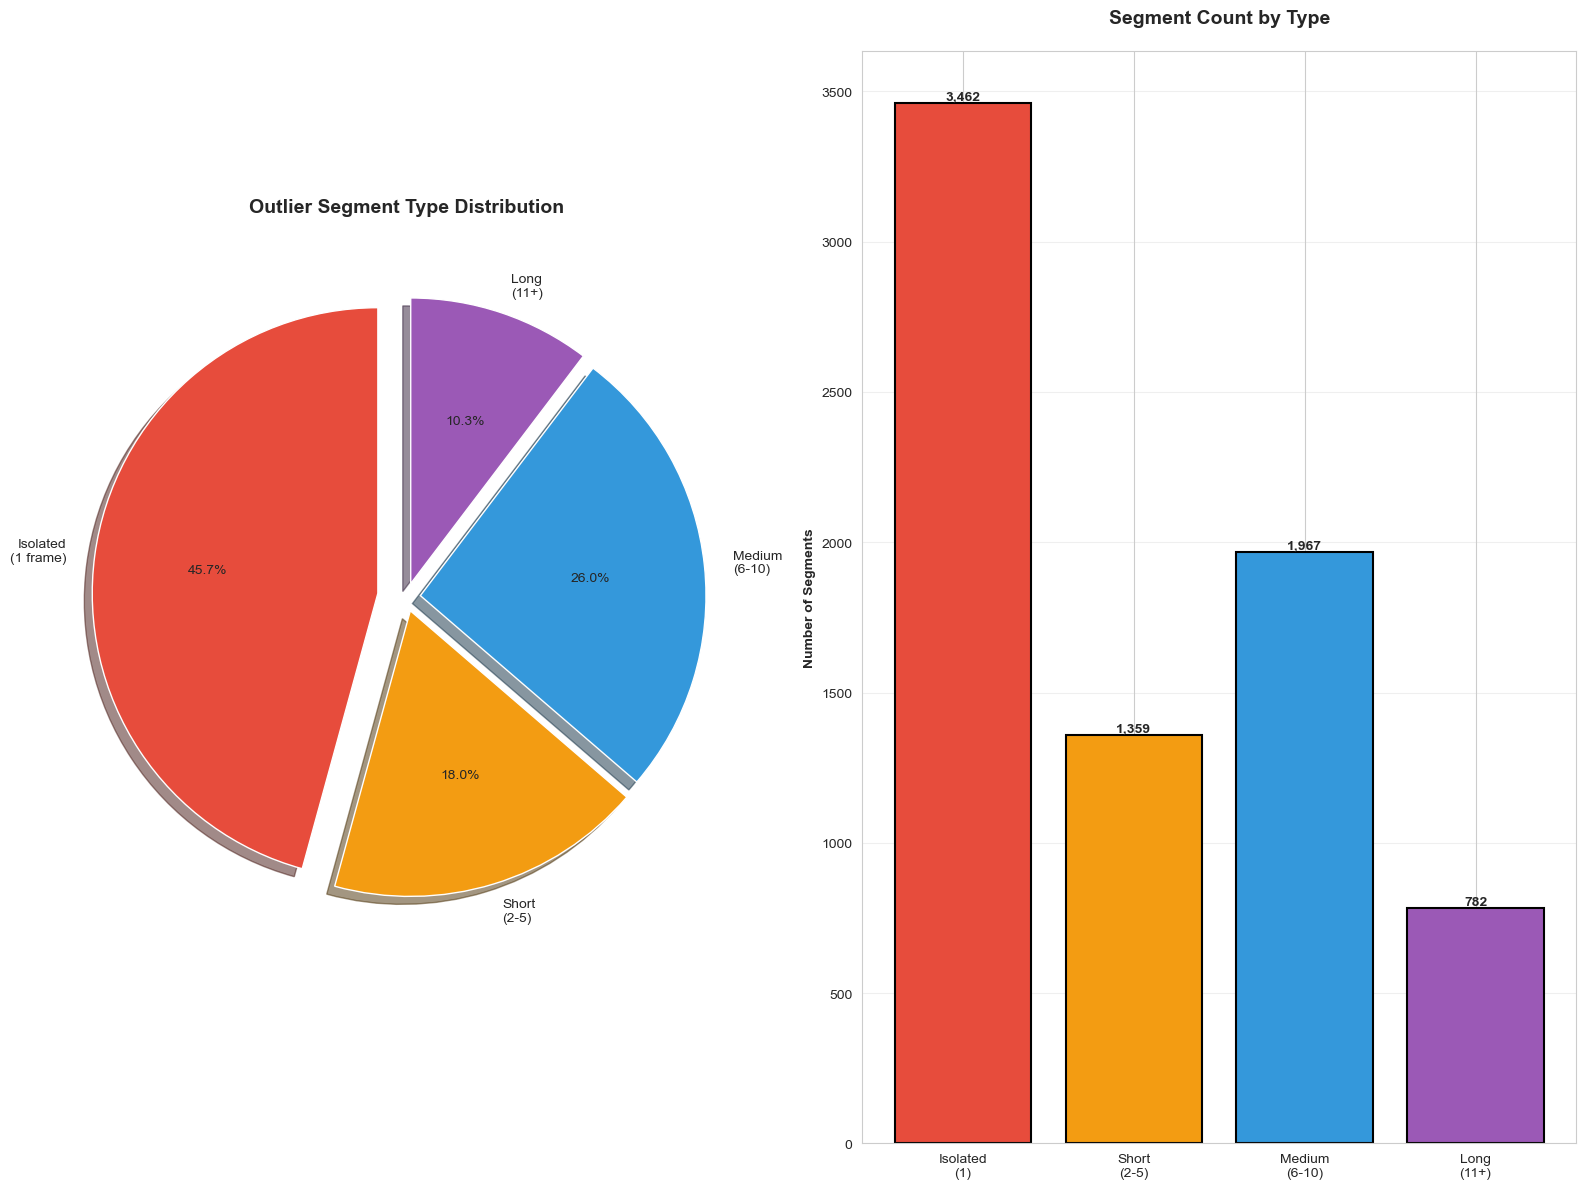

In [8]:
# Analyze consecutive outlier segments
def analyze_segments(video_df):
    """Analyze outlier segments in a single video."""
    outlier_frames = video_df[video_df['is_outlier'] == 1]['frame_id'].values
    
    if len(outlier_frames) == 0:
        return []
    
    segments = []
    current_segment = [outlier_frames[0]]
    
    for i in range(1, len(outlier_frames)):
        if outlier_frames[i] == outlier_frames[i-1] + 1:
            current_segment.append(outlier_frames[i])
        else:
            segments.append(len(current_segment))
            current_segment = [outlier_frames[i]]
    
    segments.append(len(current_segment))
    return segments

# Analyze all videos
all_segments = []
for video_id in df_all['video_id'].unique():
    video_df = df_all[df_all['video_id'] == video_id]
    segments = analyze_segments(video_df)
    all_segments.extend(segments)

# Categorize segments
isolated = sum(1 for s in all_segments if s == 1)
short_consecutive = sum(1 for s in all_segments if 2 <= s <= 5)
medium_consecutive = sum(1 for s in all_segments if 6 <= s <= 10)
long_consecutive = sum(1 for s in all_segments if s > 10)

print("Outlier Segment Analysis:")
print("=" * 60)
print(f"Total segments: {len(all_segments)}")
print(f"\nSegment Types:")
print(f"  Isolated (1 frame):           {isolated:5,} ({isolated/len(all_segments)*100:5.1f}%)")
print(f"  Short consecutive (2-5):      {short_consecutive:5,} ({short_consecutive/len(all_segments)*100:5.1f}%)")
print(f"  Medium consecutive (6-10):    {medium_consecutive:5,} ({medium_consecutive/len(all_segments)*100:5.1f}%)")
print(f"  Long consecutive (11+):       {long_consecutive:5,} ({long_consecutive/len(all_segments)*100:5.1f}%)")
print(f"\nAverage segment length: {np.mean(all_segments):.2f} frames")
print(f"Median segment length:  {np.median(all_segments):.0f} frames")
print(f"Max segment length:     {max(all_segments)} frames")

# Visualization
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(16, 12))

# 1. Segment type distribution (pie chart)
segment_types = ['Isolated\n(1 frame)', 'Short\n(2-5)', 'Medium\n(6-10)', 'Long\n(11+)']
segment_counts = [isolated, short_consecutive, medium_consecutive, long_consecutive]
colors_seg = ['#E74C3C', '#F39C12', '#3498DB', '#9B59B6']
explode = (0.1, 0.05, 0.05, 0.05)

ax1.pie(segment_counts, labels=segment_types, autopct='%1.1f%%', colors=colors_seg,
        explode=explode, shadow=True, startangle=90)
ax1.set_title('Outlier Segment Type Distribution', fontsize=14, fontweight='bold', pad=20)

# 3. Bar chart of segment types
bars = ax2.bar(range(4), segment_counts, color=colors_seg, edgecolor='black', linewidth=1.5)
ax2.set_xticks(range(4))
ax2.set_xticklabels(['Isolated\n(1)', 'Short\n(2-5)', 'Medium\n(6-10)', 'Long\n(11+)'])
ax2.set_ylabel('Number of Segments', fontweight='bold')
ax2.set_title('Segment Count by Type', fontsize=14, fontweight='bold', pad=20)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontweight='bold')


plt.tight_layout()
plt.savefig('./outlier_artifacts/statistics/analysis_segment_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Action Category Statistics

Top 10 Actions by Video Count:
                num_videos  total_frames  outlier_frames  outlier_percentage
action                                                                      
ApplyEyeMakeup          25          6976            1368           19.610092
ApplyLipstick           25          6847            1100           16.065430
Archery                 25          6244            1059           16.960282
BabyCrawling            25          6337            1133           17.879123
BalanceBeam             25          4562             767           16.812801
BandMarching            25          8398            1273           15.158371
BaseballPitch           25          3833             631           16.462301
Basketball              25          5370             902           16.797020
BasketballDunk          25          2807             415           14.784467
BenchPress              25          7103            1363           19.189075


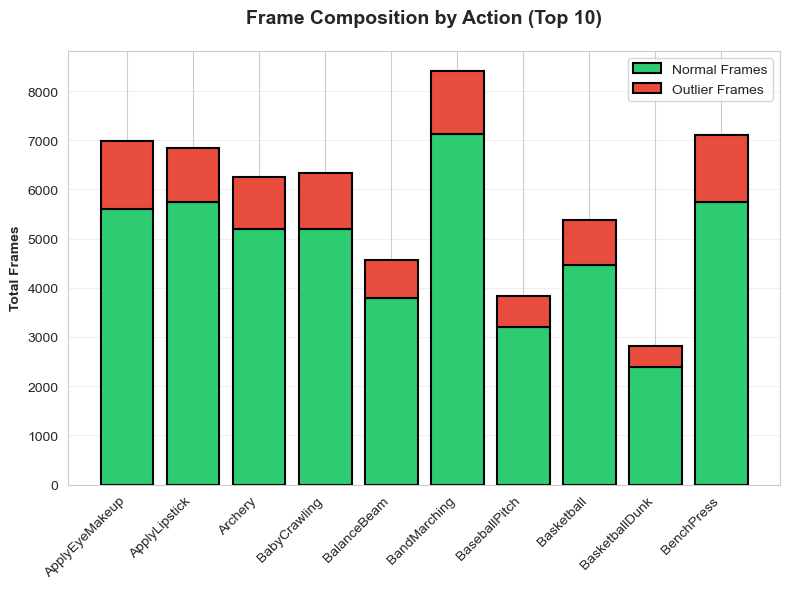

In [9]:
# Per-action statistics
action_stats = df_all.groupby('action').agg({
    'video_id': 'nunique',
    'frame_id': 'count',
    'is_outlier': 'sum'
}).rename(columns={
    'video_id': 'num_videos',
    'frame_id': 'total_frames',
    'is_outlier': 'outlier_frames'
})

action_stats['normal_frames'] = action_stats['total_frames'] - action_stats['outlier_frames']
action_stats['outlier_percentage'] = (action_stats['outlier_frames'] / action_stats['total_frames']) * 100

# Top 10 actions by video count
top_actions = action_stats.nlargest(10, 'num_videos')

print("Top 10 Actions by Video Count:")
print("=" * 80)
print(top_actions[['num_videos', 'total_frames', 'outlier_frames', 'outlier_percentage']].to_string())

# Visualization
fig, (ax) = plt.subplots(1, 1, figsize=(8, 6))

# Stacked bar chart: normal vs outlier frames
x = range(len(top_actions))
ax.bar(x, top_actions['normal_frames'], label='Normal Frames', color='#2ECC71', 
        edgecolor='black', linewidth=1.5)
ax.bar(x, top_actions['outlier_frames'], bottom=top_actions['normal_frames'],
        label='Outlier Frames', color='#E74C3C', edgecolor='black', linewidth=1.5)
ax.set_xticks(x)
ax.set_xticklabels(top_actions.index, rotation=45, ha='right')
ax.set_ylabel('Total Frames', fontweight='bold')
ax.set_title('Frame Composition by Action (Top 10)', fontsize=14, fontweight='bold', pad=20)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./outlier_artifacts/statistics/analysis_action_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

All visualizations have been saved to the `outlier_artifacts` folder.